In [1]:
# libraries for data handling
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# libraries specific for Kaggle
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# libraries for visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


/kaggle/input/art-garfunkels-library/Art Garfunkel Library.csv


In [2]:
df = pd.read_csv("/kaggle/input/art-garfunkels-library/Art Garfunkel Library.csv")

In [3]:
df.head()

,Date Read,Author,Books,Year Published,Pages,Favorite
0,Jun-68,Jean-Jacques Rousseau,The Confessions,1781,606,1
1,Jun-68,Erich Fromm,The Art of Loving,1956,146,1
2,Jun-68,Mark Twain,The Adventures of Huckleberry Finn,1884,288,0
3,Jul-68,James Thurber,My Life and Hard Times,1933,115,0
4,Jul-68,William Shakespeare,Romeo and Juliet,1596,146,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1321 entries, 0 to 1320
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date Read       1321 non-null   object
 1   Author          1321 non-null   object
 2   Books           1321 non-null   object
 3   Year Published  1321 non-null   object
 4   Pages           1321 non-null   int64 
 5   Favorite        1321 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 62.0+ KB


## Books

In [5]:
df["Books"].value_counts()

The Confessions                               3
Autobiography                                 3
The Last Interview                            2
Othello                                       2
The Europeans                                 2
                                             ..
The Solace of Open Spaces                     1
Notes from the Underground                    1
Tom Sawyer Abroad and Tom Sawyer Detective    1
Singers and the Song                          1
Saving Freedom                                1
Name: Books, Length: 1305, dtype: int64

In [6]:
# different books?
df[df["Books"]=="Othello"]

,Date Read,Author,Books,Year Published,Pages,Favorite
49,Jan-71,William Shakespeare,Othello,1602,128,0
317,Oct-84,William Shakespeare,Othello,1604,154,0


In [7]:
df[df["Books"].duplicated()].sort_values(by = "Books")

,Date Read,Author,Books,Year Published,Pages,Favorite
167,Dec-79,W.B. Yeats,Autobiography,1922,387,0
192,Jul-81,Benvenuto Cellini,Autobiography,1562,397,0
262,Sep-83,Aaron Copland,Copland on Music,1959,280,0
1192,Oct-13,Witold Gombrowicz,Cosmos,1967,208,0
836,Dec-00,Sir Harold Nicolson,Diplomacy,1939,151,0
881,Jan-03,"Lucien Febvr, Henri-Jean Martin",Good Behavior,1958,360,0
1085,Nov-09,D.A.F. Marquis deSade,Justine,1787,784,0
281,Feb-84,Richard Price,Ladies' Man,1978,264,0
526,Jul-90,Edith Hamilton,Mythology,1940,321,0
317,Oct-84,William Shakespeare,Othello,1604,154,0


In [8]:
# no fav books in duplicates and therefore favorits dont change between rereads 
df[df["Books"].duplicated()]["Favorite"].sum()

0

## Favorite

<AxesSubplot:xlabel='Favorite', ylabel='count'>

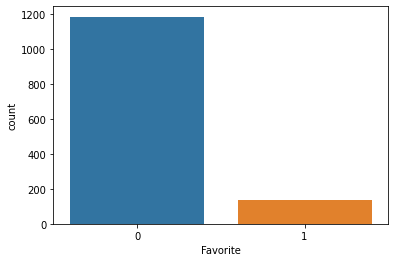

In [9]:
sns.countplot(x = "Favorite", data = df)

In [10]:
print(round(((df[df["Favorite"] ==1].shape[0]/df.shape[0])*100),3), "% of the books were favorites")

10.295 % of the books were favorites


## Author

In [11]:
df["Author"].value_counts()

William Shakespeare      15
Charles Dickens          10
Jean-Jacques Rousseau     9
Marcel Proust             8
Various                   7
                         ..
J.P. Kenyon               1
Michel Foucault           1
Ian Frazier               1
Anne Rice                 1
Joe Scarborough           1
Name: Author, Length: 966, dtype: int64

In [12]:
# favorite authors exist
df.groupby("Author")["Favorite"].sum().sort_values(ascending=False)

Author
Marcel Proust                    5
L.N. Tolstoy                     4
Jean Rhys                        3
Vladimir Nabokov                 2
Mark Twain                       2
                                ..
Giambattista Vico                0
Giorgio Vasari                   0
Giovanni Boccaccio               0
Giovanni Pico della Mirandola    0
editor, Eric L. McKitrick        0
Name: Favorite, Length: 966, dtype: int64

In [13]:
# multiple author books
#df["Author"].unique()

df["Author"].str.split(',', expand=True).dropna()

,0,1,2,3
211,David C. Gompert,Michael Mandelbaum,Richard L. Garwin,John H. Barton
213,Willard Gaylin,Ira Glasser,Steven Marcus,David Rochman
275,Sappho,Pindar,Solon,and 23 others
708,Robin,Liza,Linda,Tiffany


## pages

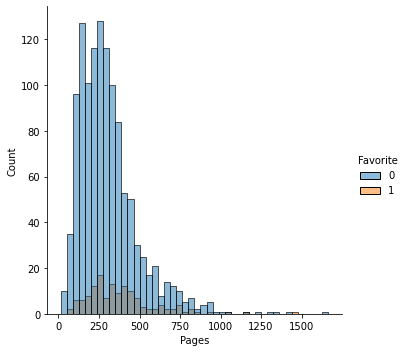

In [14]:
sns.displot(x= "Pages", data = df, hue = "Favorite")

<AxesSubplot:xlabel='Pages'>

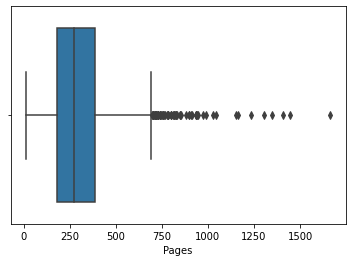

In [15]:
sns.boxplot(x= "Pages", data = df, )

# Year published 

typos and BC/AC dates need to be fixed or python will handle these as objects/string

In [16]:
df[df["Year Published"]=="730bc"]

,Date Read,Author,Books,Year Published,Pages,Favorite
139,Jun-78,Homer,The Iliad,730bc,459,0


In [17]:
# rectify the two typos
df["Year Published"].replace(["1,981","398ad"], ["1981","398"],  inplace = True)

# convert BC dates to negative numbers
df["Year_Published_numerical"] = df["Year Published"].apply(lambda x: "-"+x[:-2] if x[-2:]=="bc" else x)

# revise the data to numerical values
df["Year_Published_numerical"] = df["Year_Published_numerical"].astype(int)

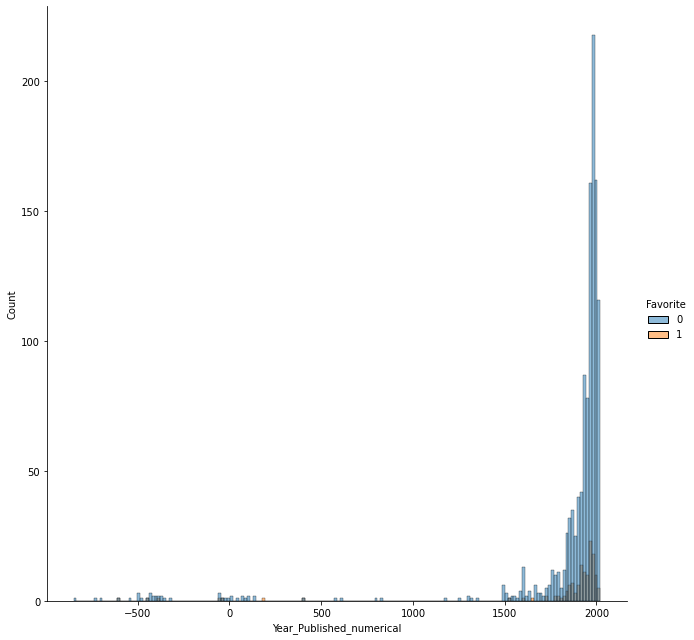

In [18]:
sns.displot(x = "Year_Published_numerical", data = df, hue = "Favorite", height = 9)
plt.show()

# Date Read

In [19]:
df["Date Read"].unique()

array(['Jun-68', 'Jul-68', 'Aug-68', 'Sep-68', 'Oct-68', 'Nov-68',
       'Dec-68', 'Jan-69', 'Feb-69', 'May-69', 'Jun-69', 'Jul-69',
       'Aug-69', 'Sep-69', 'Jan-70', 'Feb-70', 'Mar-70', 'Apr-70',
       'May-70', 'Jul-70', 'Aug-70', 'Sep-70', 'Oct-70', 'Nov-70',
       'Dec-70', 'Jan-71', 'Feb-71', 'Mar-71', 'Apr-71', 'Jun-71',
       'Jul-71', 'Aug-71', 'Sep-71', 'Oct-71', 'Nov-71', 'Dec-71',
       'Jan-72', 'Feb-72', 'Mar-72', 'Apr-72', 'Aug-72', 'Sep-72',
       'Oct-72', 'Feb-73', 'Apr-73', 'Jun-73', 'Jul-73', 'Aug-73',
       'Sep-73', 'Oct-73', 'Nov-73', 'Dec-73', 'Jan-74', 'Feb-74',
       'Mar-74', 'Apr-74', 'May-74', 'Jul-74', 'Aug-74', 'Oct-74',
       'Nov-74', 'Dec-74', 'Feb-75', 'Jun-75', 'Sep-75', 'Jan-76',
       'Feb-76', 'Mar-76', 'Apr-76', 'Jul-76', 'Dec-76', 'Jan-77',
       'Feb-77', 'May-77', 'Jun-77', 'Jul-77', 'Sep-77', 'Aug-77',
       'Nov-77', 'Dec-77', 'Mar-78', 'Apr-78', 'May-78', 'Jun-78',
       'Aug-78', 'Sep-78', 'Nov-78', 'Feb-79', 'Mar-79', 'May-

In [20]:
# fix syntax setting xxx for months unknown
df["Date Read"] = df["Date Read"].apply(lambda x: x if len(x)>5 else "xxx-"+x[-2:])

In [21]:
df[["Month", "Year"]] = df["Date Read"].str.split('-', expand=True)

In [22]:
df["Year"] = df["Year"].astype(int)

In [23]:
df["Year"] = df["Year"].apply(lambda x: x+2000 if x <68 else x+1900)
 

In [24]:
df[df["Month"]=="xxx"].shape[0]

125

In [25]:
(df[df["Month"]=="xxx"].shape[0]/df.shape[0])*100

9.462528387585163

In [26]:
(sum(df[df["Month"]=="xxx"]["Favorite"])/sum(df["Favorite"]))*100

2.941176470588235

In [27]:
df[df["Month"]=="xxx"]["Year"].unique()

array([2005, 2006, 2007, 2008, 2018, 2019, 2020, 2021])

<AxesSubplot:xlabel='Year', ylabel='count'>

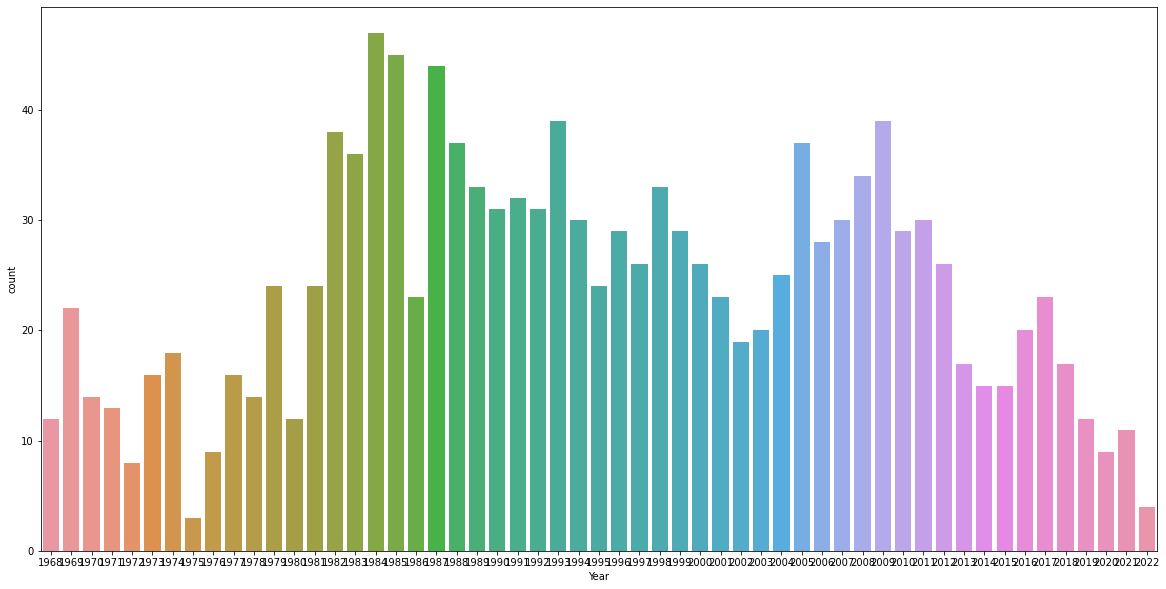

In [28]:
plt.figure(figsize = (20,10))
sns.countplot( x = "Year", data = df)

 first attempt not include month

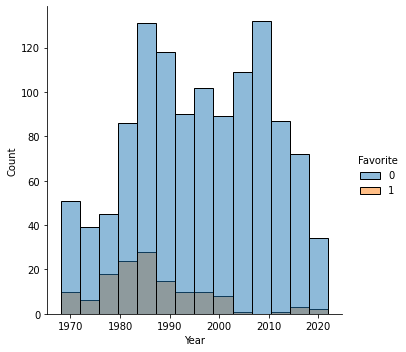

In [29]:
sns.displot(x = "Year", data = df, hue = "Favorite")

In [30]:
df[df["Month"]=="xxx"]

,Date Read,Author,Books,Year Published,Pages,Favorite,Year_Published_numerical,Month,Year
926,xxx-05,Lawrence Potter,The Persian Gulf in Transition,1997,336,0,1997,xxx,2005
927,xxx-05,Immanuel Kant,Perpetual Peace,1795,160,0,1795,xxx,2005
928,xxx-05,Bob Dylan,"Chronicles, vol. 1",2004,320,0,2004,xxx,2005
929,xxx-05,Arthur Koestler,The Gladiators,1949,44,0,1949,xxx,2005
930,xxx-05,Richard L. Bushman,From Puritan to Yankee,1967,352,0,1967,xxx,2005
...,...,...,...,...,...,...,...,...,...
1303,xxx-20,Doris Kearns Goodwin,Leadership,2020,397,0,2020,xxx,2020
1304,xxx-20,David Mikie,Stanley Kubrick,2020,248,0,2020,xxx,2020
1305,xxx-20,Julie Satow,The Plaza,2019,358,0,2019,xxx,2020
1306,xxx-20,Ash Carter and Sam Kashner,Life Isn’t Everything – Mike Nichols as Rememb...,2019,368,0,2019,xxx,2020


# Modeling favorits

In [31]:
from sklearn.preprocessing import LabelEncoder

In [32]:
le = LabelEncoder()
df["Author_code"] = le.fit_transform(df["Author"])

In [33]:
x = df[["Author_code", "Year_Published_numerical", "Pages", "Year"]]
y = df["Favorite"]

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix


In [35]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state= 101 )

In [36]:
from sklearn.linear_model import LogisticRegression

In [37]:
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)

LogisticRegression()

In [38]:
predictions = logmodel.predict(X_test)

In [39]:
from sklearn.metrics import classification_report

In [40]:
print(classification_report(y_test, predictions))
# nope.. 

              precision    recall  f1-score   support

           0       0.88      1.00      0.94       350
           1       0.00      0.00      0.00        47

    accuracy                           0.88       397
   macro avg       0.44      0.50      0.47       397
weighted avg       0.78      0.88      0.83       397



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
RandomForest = RandomForestClassifier()
RandomForest.fit(X_train, y_train)

RandomForestClassifier()

In [43]:
RandomForest_pred = RandomForest.predict(X_test)

In [44]:
print(classification_report(y_test, RandomForest_pred))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93       350
           1       0.00      0.00      0.00        47

    accuracy                           0.87       397
   macro avg       0.44      0.49      0.46       397
weighted avg       0.78      0.87      0.82       397



# month known

In [45]:
df.drop(df[df["Month"]=="xxx"].index, axis = 0, inplace = True)

In [46]:
df["Month_no"] = pd.to_datetime(df["Month"], format = "%b").dt.month

In [47]:
x = df[["Author_code","Month_no", "Year_Published_numerical", "Pages", "Year"]]
y = df["Favorite"]

In [48]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state= 101 )

In [49]:
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)

LogisticRegression()

In [50]:
predictions = logmodel.predict(X_test)

In [51]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       314
           1       0.00      0.00      0.00        45

    accuracy                           0.87       359
   macro avg       0.44      0.50      0.47       359
weighted avg       0.77      0.87      0.82       359



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
RandomForest = RandomForestClassifier()
RandomForest.fit(X_train, y_train)

RandomForestClassifier()

In [53]:
RandomForest_pred = RandomForest.predict(X_test)

In [54]:
print(classification_report(y_test, RandomForest_pred))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       314
           1       0.29      0.04      0.08        45

    accuracy                           0.87       359
   macro avg       0.58      0.51      0.50       359
weighted avg       0.80      0.87      0.82       359

